In [1]:
using Revise
using CellBasedModels
using GLMakie
using CUDA

Precompiling CellBasedModels
  ✓ CellBasedModels
  1 dependency successfully precompiled in 18 seconds. 430 already precompiled.


# 1D

In [176]:
model = ABM(1,

    medium = Dict(
        :co2 => Float64,
        :co3 => Float64,
        :vein => Float64,
    ),

    model = Dict(
        :co2Max => Float64,
        :Dco2 => Float64,
        :Dco3 => Float64
    ),

    mediumODE = quote
        if @mediumInside()
            dt(co2) = vein*(co2Max-co2)
            dt(co3) = vein*(co2Max-co3)
        end 
    end,

    mediumAlg = CBMIntegrators.DGADI(difussionCoefs=(co2=:Dco2,co3=:Dco3)),

    platform=GPU()
);

model.declaredUpdatesCode[:mediumODE]

quote
    #= /home/gatocor/Documents/CellBasedModels.jl/src/AgentStructure/functionDE.jl:94 =#
    function (dVar_, var_, p_, t_)
        #= /home/gatocor/Documents/CellBasedModels.jl/src/AgentStructure/functionDE.jl:94 =#
        #= /home/gatocor/Documents/CellBasedModels.jl/src/AgentStructure/functionDE.jl:95 =#
        function kernel(dVar_, var_, t, dt, N, NMedium, nMax_, id, idMax_, simBox, dx, dy, dz, NAdd_, NRemove_, NSurvive_, flagSurvive_, holeFromRemoveAt_, repositionAgentInPos_, x, xₘ, Dco3, co2Max, Dco2, vein)
            #= /home/gatocor/Documents/CellBasedModels.jl/src/AgentStructure/functionDE.jl:95 =#
            #= /home/gatocor/Documents/CellBasedModels.jl/src/AgentStructure/functionDE.jl:96 =#
            begin
                #= /home/gatocor/Documents/CellBasedModels.jl/src/AgentStructure/functionDE.jl:19 =#
                #= /home/gatocor/Documents/CellBasedModels.jl/src/AgentStructure/functionDE.jl:34 =# @views dt__co3 = dVar_[1, :]
                #= /home/gato

In [206]:
nx = 10^2
xmax = 1
dx = xmax/nx
x = range(0,1,length=nx)
u0 = zeros(nx)

com = Community(model,dt=.01, N=0, NMedium=[nx], simBox=[0 xmax])
com.vein[round(Int,nx/2)] = 1.
com.co2Max = 1.
com.Dco2 = .01
com.Dco3 = .1

loadToPlatform!(com)
step!(com)
# @time for i in 1:200
#     step!(com)
# end
bringFromPlatform!(com)

CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}
CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}


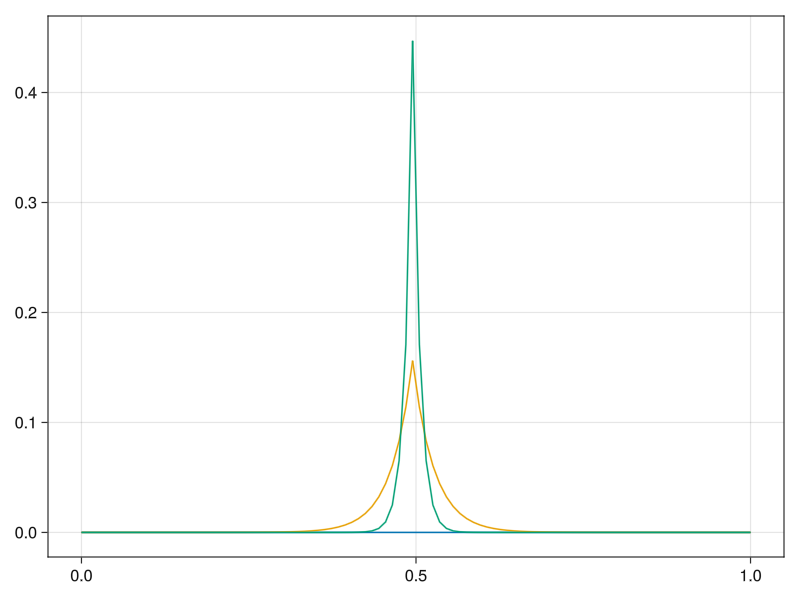

In [208]:
fig = Figure()

ax = Axis(fig[1,1])
lines!(ax, x, u0)
lines!(ax, x, com.co2)
lines!(ax, x, com.co3)

fig

# 2D

In [213]:
model = ABM(2,

    medium = Dict(
        :co2 => Float64,
        :co3 => Float64,
        :vein => Float64,
    ),

    model = Dict(
        :co2Max => Float64,
        :Dco2 => Float64,
        :Dco3 => Float64
    ),

    mediumODE = quote
        if @mediumInside()
            dt(co2) = vein*(co2Max-co2)
            dt(co3) = vein*(co2Max-co3)
        end 
    end,

    mediumAlg = CBMIntegrators.DGADI(difussionCoefs=(co2=:Dco2, co3=:Dco3)),

    platform=GPU()
);

In [214]:
nx = 101
ny = 101
xmax = 1
ymax = 1

dx = xmax/nx
dy = ymax/ny
x = range(0,1,length=nx)
y = range(0,1,length=ny)
u0 = [0 for X ∈ x, Y ∈ y]

com = Community(model,dt=0.01, N=0, NMedium=[nx,ny], simBox=[0 xmax;0 ymax])
com.vein[round(Int,nx/2),round(Int,ny/2)] = 1.
com.co2Max = 1.
com.Dco2 .= 1
com.Dco3 .= 2

loadToPlatform!(com)
@time for i in 1:500
    step!(com)
end
bringFromPlatform!(com)

  2.450963 seconds (2.77 M allocations: 173.291 MiB, 45.67% compilation time)


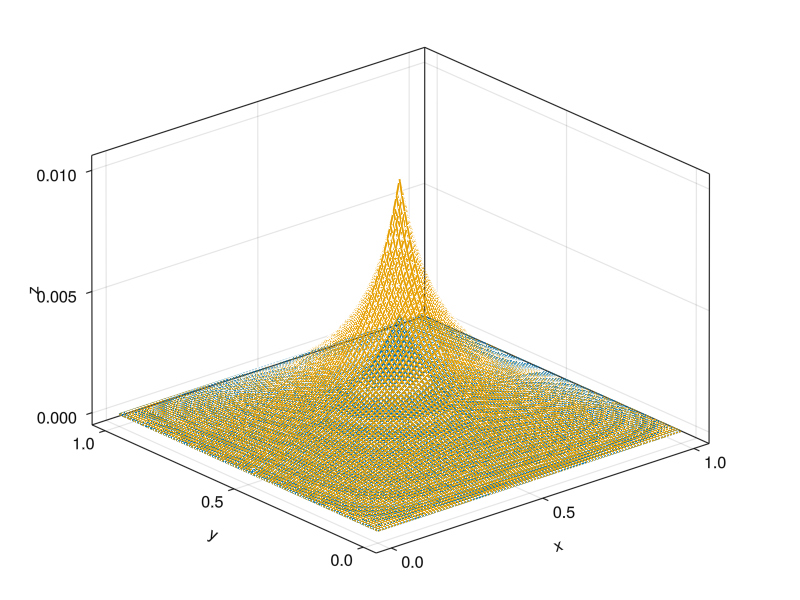

In [215]:
fig = Figure()

# ax = Axis(fig[1,1])
# heatmap!(ax, com.co2)

ax = Axis3(fig[1,1])
# wireframe!(ax, x, y, u0)
wireframe!(ax, x, y, com.co2)
wireframe!(ax, x, y, com.co3)

fig

# 3D

In [14]:
model = ABM(3,

    medium = Dict(
        :co2 => Float64,
        :vein => Float64,
        :co3 => Float64,
    ),

    model = Dict(
        :Dco3 => Float64,
        :co2Max => Float64,
        :Dco2 => Float64
    ),

    mediumODE = quote
        if @mediumInside()
            dt(co2) = vein*(co2Max-co2)
            dt(co3) = vein*(co2Max-co3)
        end 
    end,

    mediumAlg = CBMIntegrators.DGADI(difussionCoefs=(co2=:Dco2,co3=:Dco3)),

    platform=GPU()
);

In [15]:
nx = 101
ny = 101
nz = 101
xmax = 1
ymax = 1
zmax = 1

dx = xmax/nx
dy = ymax/ny
dz = zmax/nz
x = range(0,1,length=nx)
y = range(0,1,length=ny)
z = range(0,1,length=nz)
u0 = [0 for X ∈ x, Y ∈ y, Z ∈ z]

com = Community(model,dt=0.01, N=1, NMedium=[nx,ny,nz], simBox=[0 xmax;0 ymax;0 zmax])
com.x .= 0.7
com.y .= 0.5
com.z .= 0.5
com.vein[round(Int,nx/2),round(Int,ny/2),round(Int,nz/2)] = 1.
com.co2Max = 1.
com.co2 .= 0.
com.Dco2 .= 1
com.Dco3 .= 2

loadToPlatform!(com)
step!(com)
@time for i in 1:200
    step!(com)
end
bringFromPlatform!(com)

 10.639115 seconds (420.69 k allocations: 12.721 MiB)


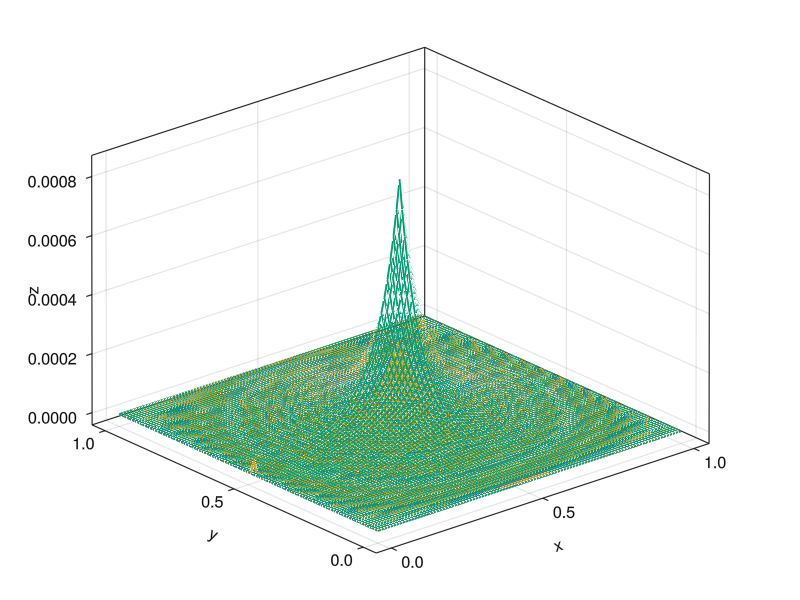

In [212]:
fig = Figure()

ax = Axis3(fig[1,1])
wireframe!(ax, x, y, u0[:,:,round(Int,nz/2)])
wireframe!(ax, x, y, com.co2[:,:,round(Int,nz/2)])
wireframe!(ax, x, y, com.co3[:,:,round(Int,nz/2)])

fig

In [5]:
for platform in [CPU(),GPU()]

    model2 = ABM(3, baseModelInit=[model], platform=platform)

    nx = 101
    ny = 101
    nz = 101
    xmax = 1
    ymax = 1
    zmax = 1

    dx = xmax/nx
    dy = ymax/ny
    dz = zmax/nz
    x = range(0,1,length=nx)
    y = range(0,1,length=ny)
    z = range(0,1,length=nz)
    u0 = [0 for X ∈ x, Y ∈ y, Z ∈ z]

    com = Community(model2,dt=0.01, N=0, NMedium=[nx,ny,nz], simBox=[0 xmax;0 ymax;0 zmax])
    com.vein[round(Int,nx/2),round(Int,ny/2),round(Int,nz/2)] = 1.
    com.co2Max = 1.
    com.co2 .= 0.
    com.Dco2 .= 1
    com.Dco3 .= 2

    loadToPlatform!(com)
    step!(com)
    @time for i in 1:200
        step!(com)
    end
    bringFromPlatform!(com)

end

LoadError: OutOfMemoryError()